# Import important libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import required libraries

In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
import numpy as np
import pandas as pd
import cv2

In [2]:
folder_path='/content/animal_dataset_intermediate/'

# Downloading data 

In [3]:

gdd.download_file_from_google_drive(file_id='176E-pLhoxTgWsJ3MeoJQV_GXczIA6g8D',
                                    dest_path='/content/animals.zip',
                                    unzip=True)


Unzipping...Done.


# Checking the total number of training data for each class

In [4]:
class_samples={}
for val in pathlib.Path(folder_path+'train').iterdir():
  count=0
  for val1 in pathlib.Path(val).iterdir():
    if val1.is_file():
      count+=1
  class_name=str(val).split('/')[-1]
  class_name=class_name.split('_')[0]
  class_samples[class_name]=count
  print('The class {} has {} number of training data'.format(class_name,count))
  

The class farfalla has 1901 number of training data
The class elefante has 1302 number of training data
The class mucca has 1680 number of training data
The class scoiattolo has 1676 number of training data
The class pecora has 1639 number of training data


In [5]:
class_samples

{'elefante': 1302,
 'farfalla': 1901,
 'mucca': 1680,
 'pecora': 1639,
 'scoiattolo': 1676}

# From the above data we see the class farfalla_train has more training data compared to other class. There is a slight class imbalance among all the classes. We will try to use class_weight or focal_loss for fine tuning the deep learning model which we are going to use

# Let's visualize the data

In [6]:
image_size = (512, 512)
valid_image_size=(480,480)
batch_size = 128

train_ds = image_dataset_from_directory(
    folder_path+"train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1400,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds =image_dataset_from_directory(
    folder_path+"train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1400,
    image_size=valid_image_size,
    batch_size=batch_size,
)



Found 8196 files belonging to 5 classes.
Using 6557 files for training.
Found 8196 files belonging to 5 classes.
Using 1639 files for validation.


In [7]:
DATASET_NUM_TRAIN_EXAMPLES = 6557

# This code is taken from the pre-processing code provided by raviraj

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# We see the dataset-pipeline considers the class as follows
class_0 as elefante

class_1 as farfalla

class_2 as mucca

class_3 as pecora

class_4 as scoiattolo

In [9]:
 labels=['elefante','farfalla','mucca','pecora','scoiattolo']
 #label[2]='mucca'
 #label pecora (sheep), elefante (elephant), farfalla (butterfly) and scoiattolo (squirrel)

# Calculating class_weight for handling the small class imbalance

In [10]:
Total_samples=sum(class_samples.values())
Total_samples

8198

In [11]:
NUM_CLASSES= len(next(os.walk(folder_path+'train'))[1])
NUM_CLASSES

5

In [12]:
class_weight={}

for idx, val in enumerate(labels):
  class_weight[idx] = Total_samples/(NUM_CLASSES*class_samples[val])

In [13]:
class_weight

{0: 1.2592933947772658,
 1: 0.862493424513414,
 2: 0.9759523809523809,
 3: 1.000366076876144,
 4: 0.9782816229116945}

# Putting the test folder inside a new folder to avoid error when creating test pipeline

In [14]:
! mkdir '/content/animal_dataset_intermediate/testing'

In [15]:
! cp -r '/content/animal_dataset_intermediate/test' '/content/animal_dataset_intermediate/testing'

In [16]:
test_ds = image_dataset_from_directory(
    folder_path+"testing",
    labels = "inferred",
    label_mode = 'int',
    seed=1400,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 910 files belonging to 1 classes.


# Preprocessing functions required for getting the data ready

In [17]:
CROP_TO=480
input_image_dim=480

In [18]:
def cast_to_dict(image,label):
  value={}
  value['image']=image
  value['label']=label
  return value 


def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  #features['image'] = tf.image.random_flip_up_down(features['image'])
  #features['image'] = tf.image.rot90(features['image'],k=1)
  features['image'] = tf.image.random_crop(features['image'], [tf.shape(features['image'])[0],CROP_TO, CROP_TO,3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_valid(features):
  #features['image']=tf.image.resize(features['image'], [tf.shape(features['image'])[0],input_image_dim, input_image_dim,3]))
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(image,label):
  image = tf.cast(image, tf.float32) / 255.0
  return image

def preprocess_test_aug(image,label):
  image=tf.image.random_flip_left_right(image)
  image = tf.cast(image, tf.float32) / 255.0
  return image

In [19]:
augmented_train_ds_ann = train_ds.map(cast_to_dict).map(preprocess_train).map(cast_to_tuple)
pipeline_valid_ann = val_ds.map(cast_to_dict).map(preprocess_valid).map(cast_to_tuple)

# Setting hyper-parameters

In [20]:
SCHEDULE_BOUNDARIES = [20, 40, 60]
BATCH_SIZE = 128
lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Model - 1 (ANN)

# Creating 3 Dense layers with 256,512,1024 neurons respectively . Adding dropout to regularize the network

# Final Dense layer have 5 neurons since the number of classes is 5 here

In [21]:
model_ann=tf.keras.Sequential([
                               tf.keras.layers.Flatten(input_shape=(input_image_dim,input_image_dim,3)),
                               tf.keras.layers.Dense(256,activation=tf.keras.activations.tanh),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(512,activation=tf.keras.activations.tanh),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(1024,activation=tf.keras.activations.tanh),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(NUM_CLASSES, kernel_initializer='zeros',activation=tf.keras.activations.softmax),
                         
])

In [22]:
model_ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 691200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               176947456 
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [23]:
model_ann.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


In [25]:
history_ann = model_ann.fit(
        augmented_train_ds_ann,
        epochs=30,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_valid_ann  # here we are only using 
                                   # this data to evaluate our performance
        
)

Epoch 1/30
52/52 [==============================] - 59s 1s/step - loss: 1.6050 - accuracy: 0.2256 - val_loss: 1.6041 - val_accuracy: 0.2355
Epoch 2/30
52/52 [==============================] - 60s 1s/step - loss: 1.6048 - accuracy: 0.2317 - val_loss: 1.6041 - val_accuracy: 0.2355
Epoch 3/30
52/52 [==============================] - 59s 1s/step - loss: 1.6050 - accuracy: 0.2224 - val_loss: 1.6041 - val_accuracy: 0.2361
Epoch 4/30
52/52 [==============================] - 59s 1s/step - loss: 1.6049 - accuracy: 0.2256 - val_loss: 1.6041 - val_accuracy: 0.2355
Epoch 5/30
52/52 [==============================] - 59s 1s/step - loss: 1.6043 - accuracy: 0.2330 - val_loss: 1.6041 - val_accuracy: 0.2361
Epoch 6/30
52/52 [==============================] - 59s 1s/step - loss: 1.6049 - accuracy: 0.2248 - val_loss: 1.6041 - val_accuracy: 0.2361
Epoch 7/30
52/52 [==============================] - 60s 1s/step - loss: 1.6045 - accuracy: 0.2306 - val_loss: 1.6041 - val_accuracy: 0.2361
Epoch 8/30
52/52 [==

In [31]:
def plot_results(history):
  print(history.history.keys())
#  "Accuracy"
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


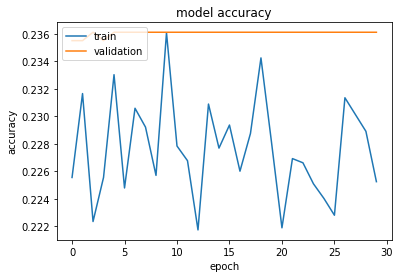

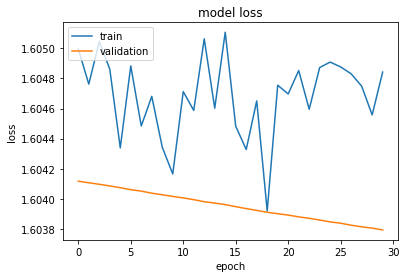

In [32]:
plot_results(history_ann)

# Model is producing 23.6% accuracy after training for 30 epochs which is little more than random guessing(20%) for 5 classes

# Method - 2 (Resnet50 (finetuning))

# I am going to fine-tune the deeplearning model Resnet50 provided by Bit transfer. The code and the idea are modified from the below link
https://github.com/google-research/big_transfer/blob/master/colabs/big_transfer_tf2.ipynb

Resnet50 -"BiT-M", pre-trained on ImageNet-21k I am going to use here. For more information about the paper, please follow the below link

https://arxiv.org/abs/1912.11370

In [39]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)

# Some other hyper-parameters mentioned in the paper to finetune the model

In [40]:
RESIZE_TO = 512
CROP_TO = 480
# SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [4, 8, 12]
BATCH_SIZE = 128
# SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
# STEPS_PER_EPOCH = 10

# Create a class which uses the resnet model + 1 fully connected layer with 5 neurons

In [41]:
class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    # Create a fully connected layer to predict the final score
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

In [ ]:
model.summary()

Model: "my_bi_t_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  10245     
_________________________________________________________________
keras_layer (KerasLayer)     multiple                  23500352  
Total params: 23,510,597
Trainable params: 10,245
Non-trainable params: 23,500,352
_________________________________________________________________


In [42]:
image_size = (512, 512)
# valid_image_size=(480,480)
batch_size = 128

train_ds = image_dataset_from_directory(
    folder_path+"train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1400,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds =image_dataset_from_directory(
    folder_path+"train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1400,
    image_size=image_size,
    batch_size=batch_size,
)



Found 8196 files belonging to 5 classes.
Using 6557 files for training.
Found 8196 files belonging to 5 classes.
Using 1639 files for validation.


# Creating preprocessing function according to the paper

In [43]:
def cast_to_dict(image,label):
  value={}
  value['image']=image
  value['label']=label
  return value 


def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  #features['image'] = tf.image.random_flip_up_down(features['image'])
  #features['image'] = tf.image.rot90(features['image'],k=1)
  features['image'] = tf.image.random_crop(features['image'], [tf.shape(features['image'])[0],CROP_TO, CROP_TO,3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_valid(features):
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(image,label):
  image = tf.cast(image, tf.float32) / 255.0
  return image

def preprocess_test_aug(image,label):
  image=tf.image.random_flip_left_right(image)
  image = tf.cast(image, tf.float32) / 255.0
  return image

# Creating Pipeline for train and valid pipeline

In [44]:
augmented_train_ds = train_ds.map(cast_to_dict).map(preprocess_train).map(cast_to_tuple)

In [45]:
pipeline_valid = val_ds.map(cast_to_dict).map(preprocess_valid).map(cast_to_tuple)

# Hyperparameter 

In [46]:
lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# First Submission without handling class imbalance

In [47]:
#model=hub.KerasLayer('/content/drive/My Drive/animal_dataset_intermediate.zip (Unzipped Files)/animal_dataset_intermediate/',trainable=True)

In [48]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


In [49]:
history_cnn = model.fit(
        augmented_train_ds,
        epochs=10,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_valid  # here we are only using 
                                   # this data to evaluate our performance
        
)

Epoch 1/10
52/52 [==============================] - 316s 6s/step - loss: 0.2744 - accuracy: 0.9486 - val_loss: 0.2188 - val_accuracy: 0.9780
Epoch 2/10
52/52 [==============================] - 303s 6s/step - loss: 0.2070 - accuracy: 0.9805 - val_loss: 0.2179 - val_accuracy: 0.9786
Epoch 3/10
52/52 [==============================] - 304s 6s/step - loss: 0.2063 - accuracy: 0.9806 - val_loss: 0.2170 - val_accuracy: 0.9786
Epoch 4/10
52/52 [==============================] - 304s 6s/step - loss: 0.2051 - accuracy: 0.9812 - val_loss: 0.2161 - val_accuracy: 0.9786
Epoch 5/10
52/52 [==============================] - 304s 6s/step - loss: 0.2040 - accuracy: 0.9814 - val_loss: 0.2152 - val_accuracy: 0.9786
Epoch 6/10
52/52 [==============================] - 304s 6s/step - loss: 0.2029 - accuracy: 0.9825 - val_loss: 0.2143 - val_accuracy: 0.9793
Epoch 7/10
52/52 [==============================] - 304s 6s/step - loss: 0.2025 - accuracy: 0.9826 - val_loss: 0.2134 - val_accuracy: 0.9793
Epoch 8/10
52

# This model achieves 99.45% accuracy on the test set. Let's see whether we get any improvement on the test data set if we run for another 5 epochs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


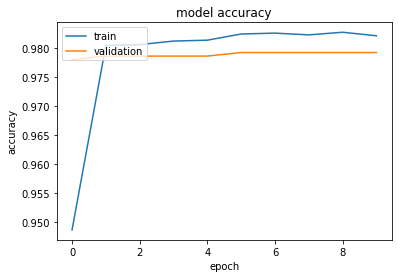

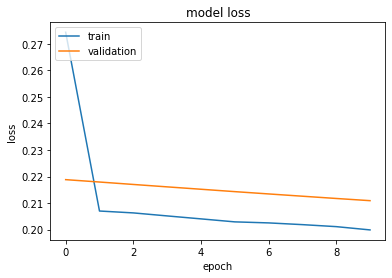

In [50]:
plot_results(history_cnn)

In [ ]:
history_cnn = model.fit(
        augmented_train_ds,
        epochs=5,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_valid  # here we are only using 
                                   # this data to evaluate our performance
        
)

Epoch 1/5
52/52 [==============================] - 187s 4s/step - loss: 0.1591 - accuracy: 0.9881 - val_loss: 0.1714 - val_accuracy: 0.9817
Epoch 2/5
52/52 [==============================] - 187s 4s/step - loss: 0.1591 - accuracy: 0.9876 - val_loss: 0.1710 - val_accuracy: 0.9817
Epoch 3/5
52/52 [==============================] - 187s 4s/step - loss: 0.1588 - accuracy: 0.9880 - val_loss: 0.1707 - val_accuracy: 0.9823
Epoch 4/5
52/52 [==============================] - 187s 4s/step - loss: 0.1580 - accuracy: 0.9884 - val_loss: 0.1703 - val_accuracy: 0.9823
Epoch 5/5
52/52 [==============================] - 187s 4s/step - loss: 0.1580 - accuracy: 0.9873 - val_loss: 0.1700 - val_accuracy: 0.9817


# This model achieves 99.45% accuracy which is same as previous model. Since Loss is decreasing , Let's try for another 5 epochs

In [ ]:
history_cnn = model.fit(
        augmented_train_ds,
        epochs=5,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_valid  # here we are only using 
                                   # this data to evaluate our performance
        
)

Epoch 1/5
52/52 [==============================] - 188s 4s/step - loss: 0.1571 - accuracy: 0.9886 - val_loss: 0.1696 - val_accuracy: 0.9817
Epoch 2/5
52/52 [==============================] - 187s 4s/step - loss: 0.1570 - accuracy: 0.9875 - val_loss: 0.1693 - val_accuracy: 0.9817
Epoch 3/5
52/52 [==============================] - 187s 4s/step - loss: 0.1570 - accuracy: 0.9883 - val_loss: 0.1689 - val_accuracy: 0.9817
Epoch 4/5
52/52 [==============================] - 187s 4s/step - loss: 0.1563 - accuracy: 0.9872 - val_loss: 0.1686 - val_accuracy: 0.9817
Epoch 5/5
52/52 [==============================] - 187s 4s/step - loss: 0.1563 - accuracy: 0.9876 - val_loss: 0.1683 - val_accuracy: 0.9817


# This model achieves 99.34% accuracy, so we can use the model trained with 15 epochs as the final model

In [ ]:
model.load_weights('/content/drive/My Drive/animal_dataset_intermediate.zip (Unzipped Files)/animal_dataset_intermediate/initial_model_2.h5')

# Now Adding class_weight to handle class imbalance and see if we see any improvement in the output

# Let's try to use the class_weights which we have calculated before to train the model for another 5 epochs and see if we get some improvement

In [ ]:
history_cnn = model.fit(
        augmented_train_ds,
        epochs=5,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_valid,  # here we are only using 
        class_weight=class_weight                        # this data to evaluate our performance
        
)

Epoch 1/5
52/52 [==============================] - 188s 4s/step - loss: 0.1612 - accuracy: 0.9876 - val_loss: 0.1749 - val_accuracy: 0.9823
Epoch 2/5
52/52 [==============================] - 188s 4s/step - loss: 0.1614 - accuracy: 0.9880 - val_loss: 0.1745 - val_accuracy: 0.9823
Epoch 3/5
52/52 [==============================] - 188s 4s/step - loss: 0.1613 - accuracy: 0.9878 - val_loss: 0.1741 - val_accuracy: 0.9823
Epoch 4/5
52/52 [==============================] - 188s 4s/step - loss: 0.1607 - accuracy: 0.9878 - val_loss: 0.1737 - val_accuracy: 0.9823
Epoch 5/5
52/52 [==============================] - 188s 4s/step - loss: 0.1606 - accuracy: 0.9886 - val_loss: 0.1733 - val_accuracy: 0.9823


In [ ]:
history_cnn = model.fit(
        augmented_train_ds,
        epochs=5,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_valid,  # here we are only using 
        class_weight=class_weight                        # this data to evaluate our performance
        
)

Epoch 1/5
52/52 [==============================] - 188s 4s/step - loss: 0.1600 - accuracy: 0.9881 - val_loss: 0.1729 - val_accuracy: 0.9823
Epoch 2/5
52/52 [==============================] - 188s 4s/step - loss: 0.1594 - accuracy: 0.9878 - val_loss: 0.1725 - val_accuracy: 0.9823
Epoch 3/5
52/52 [==============================] - 187s 4s/step - loss: 0.1596 - accuracy: 0.9880 - val_loss: 0.1721 - val_accuracy: 0.9823
Epoch 4/5
52/52 [==============================] - 188s 4s/step - loss: 0.1588 - accuracy: 0.9881 - val_loss: 0.1717 - val_accuracy: 0.9817
Epoch 5/5
52/52 [==============================] - 188s 4s/step - loss: 0.1583 - accuracy: 0.9883 - val_loss: 0.1714 - val_accuracy: 0.9817


# The model produces 99.45% accuracy so class_weight doesnot improve the accuracy in this case

# Saving the model and model weights

In [ ]:
model.save_weights('/content/drive/My Drive/animal_dataset_intermediate.zip (Unzipped Files)/animal_dataset_intermediate/initial_model_5.h5')

In [ ]:
export_module_dir = '/content/drive/My Drive/animal_dataset_intermediate.zip (Unzipped Files)/animal_dataset_intermediate/model_5'
tf.saved_model.save(model, export_module_dir)

INFO:tensorflow:Assets written to: /content/drive/My Drive/animal_dataset_intermediate.zip (Unzipped Files)/animal_dataset_intermediate/model_5/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/animal_dataset_intermediate.zip (Unzipped Files)/animal_dataset_intermediate/model_5/assets


# Adding image paths as return parameter to image_dataset_from_directory

https://stackoverflow.com/questions/62166588/how-to-obtain-filenames-during-prediction-while-using-tf-keras-preprocessing-ima

The reason I need image filenames because the test-dataset provided by the datafilename is not in the same order as the csv file (testing_set_animals.csv) . In order to match the predictions predicted by the model against the filenames present in csv file, we need the file names processed by the test-dataset pipeline

In [51]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing
from tensorflow.python.keras.preprocessing import dataset_utils
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.util.tf_export import keras_export

WHITELIST_FORMATS = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

## Tensorflow override method to return fname as list as well as dataset

def image_dataset_from_directory(directory,
                                 labels='inferred',
                                 label_mode='int',
                                 class_names=None,
                                 color_mode='rgb',
                                 batch_size=32,
                                 image_size=(256, 256),
                                 shuffle=True,
                                 seed=None,
                                 validation_split=None,
                                 subset=None,
                                 interpolation='bilinear',
                                 follow_links=False):
  
  if labels != 'inferred':
    if not isinstance(labels, (list, tuple)):
      raise ValueError(
          '`labels` argument should be a list/tuple of integer labels, of '
          'the same size as the number of image files in the target '
          'directory. If you wish to infer the labels from the subdirectory '
          'names in the target directory, pass `labels="inferred"`. '
          'If you wish to get a dataset that only contains images '
          '(no labels), pass `label_mode=None`.')
    if class_names:
      raise ValueError('You can only pass `class_names` if the labels are '
                       'inferred from the subdirectory names in the target '
                       'directory (`labels="inferred"`).')
  if label_mode not in {'int', 'categorical', 'binary', None}:
    raise ValueError(
        '`label_mode` argument must be one of "int", "categorical", "binary", '
        'or None. Received: %s' % (label_mode,))
  if color_mode == 'rgb':
    num_channels = 3
  elif color_mode == 'rgba':
    num_channels = 4
  elif color_mode == 'grayscale':
    num_channels = 1
  else:
    raise ValueError(
        '`color_mode` must be one of {"rbg", "rgba", "grayscale"}. '
        'Received: %s' % (color_mode,))
  interpolation = image_preprocessing.get_interpolation(interpolation)
  dataset_utils.check_validation_split_arg(
      validation_split, subset, shuffle, seed)

  if seed is None:
    seed = np.random.randint(1e6)
  image_paths, labels, class_names = dataset_utils.index_directory(
      directory,
      labels,
      formats=WHITELIST_FORMATS,
      class_names=class_names,
      shuffle=shuffle,
      seed=seed,
      follow_links=follow_links)

  if label_mode == 'binary' and len(class_names) != 2:
    raise ValueError(
        'When passing `label_mode="binary", there must exactly 2 classes. '
        'Found the following classes: %s' % (class_names,))

  image_paths, labels = dataset_utils.get_training_or_validation_split(
      image_paths, labels, validation_split, subset)

  dataset = paths_and_labels_to_dataset(
      image_paths=image_paths,
      image_size=image_size,
      num_channels=num_channels,
      labels=labels,
      label_mode=label_mode,
      num_classes=len(class_names),
      interpolation=interpolation)
  if shuffle:
    # Shuffle locally at each iteration
    dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
  dataset = dataset.batch(batch_size)
  # Users may need to reference `class_names`.
  dataset.class_names = class_names
  return dataset, image_paths

def paths_and_labels_to_dataset(image_paths,
                                image_size,
                                num_channels,
                                labels,
                                label_mode,
                                num_classes,
                                interpolation):
  """Constructs a dataset of images and labels."""
  # TODO(fchollet): consider making num_parallel_calls settable
  path_ds = dataset_ops.Dataset.from_tensor_slices(image_paths)
  img_ds = path_ds.map(
      lambda x: path_to_image(x, image_size, num_channels, interpolation))
  if label_mode:
    label_ds = dataset_utils.labels_to_dataset(labels, label_mode, num_classes)
    img_ds = dataset_ops.Dataset.zip((img_ds, label_ds))
  return img_ds


def path_to_image(path, image_size, num_channels, interpolation):
  img = io_ops.read_file(path)
  img = image_ops.decode_image(
      img, channels=num_channels, expand_animations=False)
  img = image_ops.resize_images_v2(img, image_size, method=interpolation)
  img.set_shape((image_size[0], image_size[1], num_channels))
  return img

# Creating Pipeline for test_images

In [52]:
image_size

(512, 512)

In [53]:
test_ds,test_paths = image_dataset_from_directory(
    folder_path+"testing",
    labels = "inferred",
    label_mode = 'int',
    seed=1400,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 910 files belonging to 1 classes.


In [54]:
pipeline_test=test_ds.map(preprocess_test)

In [55]:
#pipeline_test_aug=test_ds.map(preprocess_test_aug)

# Predict the classes

In [56]:
preds = model.predict(pipeline_test)



In [57]:
#if using softmax activation on output layer
predicted_labels  = np.argmax(preds,axis=1)

In [ ]:
#preds_aug=model.predict(pipeline_test)

In [ ]:
#predicted_labels_aug=np.argmax(preds_aug,axis=1)

In [ ]:
#predicted_labels-predicted_labels_aug

# Open the submission file

In [58]:
df=pd.read_csv('/content/animal_dataset_intermediate/Testing_set_animals.csv')

In [59]:
temp_df=df.copy()

In [60]:
for i, val in enumerate(test_paths):
  temp_df.iloc[i,0]=val

In [61]:
temp_df['target']=predicted_labels

In [62]:
''' def plot_sample_output(df):
  for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img=cv2.imread(folder_path+'testing/test/'+df['filename'][i])
        plt.imshow(img)
        #plt.title(int(labels[i]))
        plt.axis("off")'''

' def plot_sample_output(df):\n  for i in range(9):\n        ax = plt.subplot(3, 3, i + 1)\n        img=cv2.imread(folder_path+\'testing/test/\'+df[\'filename\'][i])\n        plt.imshow(img)\n        #plt.title(int(labels[i]))\n        plt.axis("off")'

In [65]:
def plot_sample_output_check(df,class_name=None):
  for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img=cv2.imread(df['filename'][i])
        plt.imshow(img)
        plt.title(labels[class_name])
        plt.axis("off")

In [66]:
check_class_0=temp_df.loc[temp_df['target']==0].reset_index(drop=True)

In [67]:
check_class_1=temp_df.loc[temp_df['target']==1].reset_index(drop=True)
check_class_2=temp_df.loc[temp_df['target']==2].reset_index(drop=True)
check_class_3=temp_df.loc[temp_df['target']==3].reset_index(drop=True)
check_class_4=temp_df.loc[temp_df['target']==4].reset_index(drop=True)

In [ ]:
plot_sample_output_check(check_class_0,class_name=0)

In [ ]:
plot_sample_output_check(check_class_4,class_name=4)

# Procedure to assign target class by comparing filenames in temp_df and df 

In [ ]:
for i, val in enumerate(temp_df['filename']):
  for t,j in enumerate(df['filename']):
    if val.split('/')[-1]==j:
      df.iloc[t,1]=temp_df.iloc[i,1]
      
    

In [ ]:
df.head()

,filename,target
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,1.0
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,1.0
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,1.0
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,1.0
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,1.0


In [ ]:
df['target']=df['target'].apply(lambda x: 'elefante' if x==0 else 'farfalla' if x==1 else 'mucca' if x==2 else   'pecora' if x==3 else 'scoiattolo')

In [ ]:
df.to_csv('/content/drive/My Drive/animal_dataset_intermediate.zip (Unzipped Files)/animal_dataset_intermediate/final_df_8.csv',index=False)

# Conclusion

ANN performs worst compared to CNN models for image classification task

Things I have tried in the CNN part were
1. Tried with image-resize (160x160x3) and randomly cropping (128x128x3) for training. This after trained for 10 epochs with fine-tuning has yield me a accuracy of 98.6% accuracy on the test-dataset
2. Next I have tried with image-size(512x512x3) and randomly cropping(480x480x3). The CNN model trained with this image size achieves me 99.45% accuracy on the test-dataset after 10 epochs.


Regarding hyper-parameter optimization
I have used initially SGD with momentum which provides me an accuracy of 99.34% accuracy . I changed the optimizer which got me an accuracy boost of 0.10% in the test-data



I also tried class-weight parameter(to handle little imbalance), adding more data augmentation techniques (like rot the image flip upside down) apart from the flight-left-right technique but it doesnot help me in increasing the accuracy when I tried for another 10 epochs.